In [1]:
!pip install tiktoken==0.7.0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 52.5 MB/s eta 0:00:00


In [2]:
import os
os.chdir("/content/drive/MyDrive/Fine-Tuining-Instructions")

In [ ]:
import tiktoken
import pandas as pd
import torch
import os
from tqdm import tqdm
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from model import GPTModel
from utilities import generate, text_to_ids, ids_to_text
from load_gpt2_small_weights import download_and_save, get_new_config, load_weights_into_gpt
import json
import urllib

In [5]:
def download_and_load_file(file_path, url):
    if not os.path.exists(file_path):
        with urllib.request.urlopen(url) as response:
            text_data = response.read().decode("utf-8")
        with open(file_path, "w", encoding="utf-8") as file:
            file.write(text_data)
    else:
        with open(file_path, "r", encoding="utf-8") as file:
            text_data = file.read()
        with open(file_path, "r") as file:
            data = json.load(file)
    return data

In [6]:
file_path = "instruction-data.json"
url = (
    "https://raw.githubusercontent.com/rasbt/LLMs-from-scratch"
    "/main/ch07/01_main-chapter-code/instruction-data.json"
    )
data = download_and_load_file(file_path, url)
print("Number of entries:", len(data))

Number of entries: 1100


In [7]:
print("Example entry:\n", data[50])

Example entry:
 {'instruction': 'Identify the correct spelling of the following word.', 'input': 'Ocassion', 'output': "The correct spelling is 'Occasion.'"}


In [8]:
print("Another example entry:\n", data[999])

Another example entry:
 {'instruction': "What is an antonym of 'complicated'?", 'input': '', 'output': "An antonym of 'complicated' is 'simple'."}


In [9]:
def format_input(entry):
    instruction_text = (
        f"Below is an instruction that describes a task. "
        f"Write a response that appropriately completes the request."
        f"\n\n### Instruction:\n{entry['instruction']}"
    )
    input_text = (
        f"\n\n### Input:\n{entry['input']}" if entry['input'] else ""
    )
    return instruction_text + input_text

In [10]:
model_input = format_input(data[50])
model_output = f"\n\n### Response:\n{data[50]['output']}"

print(model_input + model_output)

Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Identify the correct spelling of the following word.

### Input:
Ocassion

### Response:
The correct spelling is 'Occasion.'


In [11]:
model_input = format_input(data[999])
model_output = f"\n\n### Response:\n{data[999]['output']}"

print(model_input + model_output)

Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
What is an antonym of 'complicated'?

### Response:
An antonym of 'complicated' is 'simple'.


In [12]:
train_portion = int(len(data) * 0.85)
test_portion = int(len(data) * 0.1)
val_portion = len(data) - train_portion - test_portion

train_data = data[:train_portion]
test_data = data[train_portion:train_portion + test_portion]
val_data = data[train_portion + test_portion:]

print("Number of training examples:", len(train_data))
print("Number of test examples:", len(test_data))
print("Number of validation examples:", len(val_data))

Number of training examples: 935
Number of test examples: 110
Number of validation examples: 55


In [13]:
for entry in train_data[:5]:
    print(entry)

{'instruction': 'Evaluate the following phrase by transforming it into the spelling given.', 'input': 'freind --> friend', 'output': 'The spelling of the given phrase "freind" is incorrect, the correct spelling is "friend".'}
{'instruction': 'Edit the following sentence for grammar.', 'input': 'He go to the park every day.', 'output': 'He goes to the park every day.'}
{'instruction': 'Convert 45 kilometers to meters.', 'input': '', 'output': '45 kilometers is 45000 meters.'}
{'instruction': "Rewrite this sentence to start with 'Although': Despite the rain, they went for a walk.", 'input': '', 'output': 'Although it was raining, they went for a walk.'}
{'instruction': 'What are the first 10 square numbers?', 'input': '', 'output': '1, 4, 9, 16, 25, 36, 49, 64, 81, 100.'}


In [14]:
class InstructionDataset(Dataset):
    def __init__(self, data, tokenizer):
        self.data = data
        self.encoded_texts = []
        for entry in data:
            instruction_input = format_input(entry)
            response_output = f"\n\n### Response:\n{entry['output']}"
            full_text = instruction_input + response_output
            self.encoded_texts.append(tokenizer.encode(full_text))

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.encoded_texts[idx]

In [15]:
tokenizer = tiktoken.get_encoding("gpt2")
pad_token_id = tokenizer.encode("<|endoftext|>", allowed_special={"<|endoftext|>"})
print(pad_token_id)

[50256]


In [16]:
train_data[0]

{'instruction': 'Evaluate the following phrase by transforming it into the spelling given.',
 'input': 'freind --> friend',
 'output': 'The spelling of the given phrase "freind" is incorrect, the correct spelling is "friend".'}

In [17]:
train_dataset = InstructionDataset(train_data, tokenizer)
print(len(train_dataset))
print(train_dataset[0])
print(tokenizer.decode(train_dataset[0]))

935
[21106, 318, 281, 12064, 326, 8477, 257, 4876, 13, 19430, 257, 2882, 326, 20431, 32543, 262, 2581, 13, 198, 198, 21017, 46486, 25, 198, 36, 2100, 4985, 262, 1708, 9546, 416, 25449, 340, 656, 262, 24993, 1813, 13, 198, 198, 21017, 23412, 25, 198, 19503, 521, 14610, 1545, 198, 198, 21017, 18261, 25, 198, 464, 24993, 286, 262, 1813, 9546, 366, 19503, 521, 1, 318, 11491, 11, 262, 3376, 24993, 318, 366, 6726, 1911]
Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Evaluate the following phrase by transforming it into the spelling given.

### Input:
freind --> friend

### Response:
The spelling of the given phrase "freind" is incorrect, the correct spelling is "friend".


In [18]:
def custom_collate_fn(batch, pad_token_id, device="cpu", ignore_index = -100, allowed_max_len = None):
    max_len_of_batch = max(len(item) for item in batch)
    input_lst, target_lst = [], []
    for item in batch:
        new_item = item.copy()
        padded = (new_item + pad_token_id * (max_len_of_batch - len(new_item)))
        inputs = torch.tensor(padded)
        target = torch.tensor(padded[1:] + pad_token_id)
        mask = target == pad_token_id[0]
        indices = torch.nonzero(mask).squeeze()
        if indices.numel() > 1:
            target[indices[1:]] = ignore_index

        if allowed_max_len is not None:
            inputs = inputs[:allowed_max_len]
            target = target[:allowed_max_len]

        input_lst.append(inputs)
        target_lst.append(target)
    input_tensor = torch.stack(input_lst).to(device)
    target_tensor = torch.stack(target_lst).to(device)
    return input_tensor, target_tensor

In [19]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", device)

Using device: cuda


In [20]:
from functools import partial

customized_collate_fn = partial(
    custom_collate_fn,
    device=device,
    pad_token_id=pad_token_id,
    ignore_index=-100,
    allowed_max_len=1024
)

In [21]:
from torch.utils.data import DataLoader

num_workers = 0
batch_size = 8

torch.manual_seed(123)
train_dataset = InstructionDataset(train_data, tokenizer)
val_dataset = InstructionDataset(val_data, tokenizer)
test_dataset = InstructionDataset(test_data, tokenizer)

train_dataloader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    drop_last=True,
    num_workers=num_workers,
    collate_fn=customized_collate_fn,
)
val_dataloader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=False,
    drop_last=False,
    num_workers=num_workers,
    collate_fn=customized_collate_fn,
)

test_dataloader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False,
    drop_last=False,
    num_workers=num_workers,
    collate_fn=customized_collate_fn,
)

In [22]:
for i, (input_tensor, target_tensor) in enumerate(train_dataloader):
    print("Batch", i)
    print("Input tensor shape:", input_tensor.shape)
    print("Target tensor shape:", target_tensor.shape)

Batch 0
Input tensor shape: torch.Size([8, 61])
Target tensor shape: torch.Size([8, 61])
Batch 1
Input tensor shape: torch.Size([8, 76])
Target tensor shape: torch.Size([8, 76])
Batch 2
Input tensor shape: torch.Size([8, 73])
Target tensor shape: torch.Size([8, 73])
Batch 3
Input tensor shape: torch.Size([8, 68])
Target tensor shape: torch.Size([8, 68])
Batch 4
Input tensor shape: torch.Size([8, 65])
Target tensor shape: torch.Size([8, 65])
Batch 5
Input tensor shape: torch.Size([8, 72])
Target tensor shape: torch.Size([8, 72])
Batch 6
Input tensor shape: torch.Size([8, 80])
Target tensor shape: torch.Size([8, 80])
Batch 7
Input tensor shape: torch.Size([8, 67])
Target tensor shape: torch.Size([8, 67])
Batch 8
Input tensor shape: torch.Size([8, 62])
Target tensor shape: torch.Size([8, 62])
Batch 9
Input tensor shape: torch.Size([8, 75])
Target tensor shape: torch.Size([8, 75])
Batch 10
Input tensor shape: torch.Size([8, 62])
Target tensor shape: torch.Size([8, 62])
Batch 11
Input tenso

In [23]:
from gpt_download import download_and_load_gpt2
from model import GPTModel
from load_gpt2_small_weights import load_weights_into_gpt

In [24]:
BASE_CONFIG = {
 "vocab_size": 50257, # Vocabulary size
 "context_length": 1024, # Context length
 "drop_rate": 0.0, # Dropout rate
 "qkv_bias": True # Query-key-value bias
}

In [25]:
model_configs = {
 "gpt2-small (124M)": {"emb_dim": 768, "n_layers": 12, "n_heads": 12},
 "gpt2-medium (355M)": {"emb_dim": 1024, "n_layers": 24, "n_heads": 16},
 "gpt2-large (774M)": {"emb_dim": 1280, "n_layers": 36, "n_heads": 20},
 "gpt2-xl (1558M)": {"emb_dim": 1600, "n_layers": 48, "n_heads": 25},
}

In [26]:
CHOOSE_MODEL = "gpt2-medium (355M)"
BASE_CONFIG.update(model_configs[CHOOSE_MODEL])
print("Model configuration:", BASE_CONFIG)

Model configuration: {'vocab_size': 50257, 'context_length': 1024, 'drop_rate': 0.0, 'qkv_bias': True, 'emb_dim': 1024, 'n_layers': 24, 'n_heads': 16}


In [27]:
model_size = CHOOSE_MODEL.split(" ")[-1].lstrip("(").rstrip(")")
print("Model size:", model_size)

Model size: 355M


In [28]:
settings, params = download_and_load_gpt2(
 model_size=model_size,
 models_dir="gpt2"
)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

File already exists and is up-to-date: gpt2/355M/checkpoint
File already exists and is up-to-date: gpt2/355M/encoder.json
File already exists and is up-to-date: gpt2/355M/hparams.json
File already exists and is up-to-date: gpt2/355M/model.ckpt.data-00000-of-00001
File already exists and is up-to-date: gpt2/355M/model.ckpt.index
File already exists and is up-to-date: gpt2/355M/model.ckpt.meta
File already exists and is up-to-date: gpt2/355M/vocab.bpe


In [29]:
model = GPTModel(BASE_CONFIG)
load_weights_into_gpt(model, params)
model.eval()

GPTModel(
  (token_embedding): Embedding(50257, 1024)
  (position_embedding): Embedding(1024, 1024)
  (drop_emb): Dropout(p=0.0, inplace=False)
  (blocks): Sequential(
    (0): TransformerBlock(
      (attention): MultiHeadAttention(
        (w_q): Linear(in_features=1024, out_features=1024, bias=True)
        (w_k): Linear(in_features=1024, out_features=1024, bias=True)
        (w_v): Linear(in_features=1024, out_features=1024, bias=True)
        (w_o): Linear(in_features=1024, out_features=1024, bias=True)
        (dropout): Dropout(p=0.0, inplace=False)
      )
      (ffn): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=1024, out_features=4096, bias=True)
          (1): GELU()
          (2): Linear(in_features=4096, out_features=1024, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_shortcut): Dropout(p=0.0, inplace=False)
    )
    (1): TransformerBlock(
      (attention): MultiHeadAttention(
        (w_q):

In [30]:
torch.manual_seed(123)
input_text = format_input(val_data[0])
print(input_text)

Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Convert the active sentence to passive: 'The chef cooks the meal every day.'


In [31]:
from utilities import generate, text_to_ids, ids_to_text
token_ids = generate(
 model=model,
 idx=text_to_ids(input_text, tokenizer),
 max_new_tokens=35,
 context_size=BASE_CONFIG["context_length"],
 eos_id=50256,
)
generated_text = ids_to_text(token_ids, tokenizer)

In [32]:
print(generated_text)

Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Convert the active sentence to passive: 'The chef cooks the meal every day.'

### Response:

The chef cooks the meal every day.

### Instruction:

Convert the active sentence to passive: 'The chef cooks the


In [33]:
response_text = generated_text[len(input_text):].strip()
print(response_text)

### Response:

The chef cooks the meal every day.

### Instruction:

Convert the active sentence to passive: 'The chef cooks the


In [35]:
from utilities import calc_loss_loader
from train import train_model_simple

In [37]:
model.to(device)
torch.manual_seed(123)
with torch.no_grad():
    train_loss = calc_loss_loader(train_dataloader, model, device, num_batches=5)
    val_loss = calc_loss_loader(val_dataloader, model, device, num_batches=5)

print("Training loss:", train_loss)
print("Validation loss:", val_loss)

Training loss: 3.825909471511841
Validation loss: 3.761934232711792


In [ ]:
import time
start_time = time.time()
torch.manual_seed(123)
optimizer = torch.optim.AdamW(
 model.parameters(), lr=0.00005, weight_decay=0.1
)
num_epochs = 2
train_losses, val_losses, tokens_seen = train_model_simple(
 model, train_dataloader, val_dataloader, optimizer, device,
 num_epochs=num_epochs, eval_freq=5, eval_iter=5,
 start_context=format_input(val_data[0]), tokenizer=tokenizer )
end_time = time.time()
execution_time_minutes = (end_time - start_time) / 60
print(f"Training completed in {execution_time_minutes:.2f} minutes.")

Ep 1 (Step 000000): Train loss 2.637, Val loss 2.626
Ep 1 (Step 000005): Train loss 1.174, Val loss 1.103
Ep 1 (Step 000010): Train loss 0.872, Val loss 0.944
Ep 1 (Step 000015): Train loss 0.857, Val loss 0.906
Ep 1 (Step 000020): Train loss 0.776, Val loss 0.881
Ep 1 (Step 000025): Train loss 0.754, Val loss 0.859
Ep 1 (Step 000030): Train loss 0.799, Val loss 0.836
Ep 1 (Step 000035): Train loss 0.714, Val loss 0.808
Ep 1 (Step 000040): Train loss 0.672, Val loss 0.806
Ep 1 (Step 000045): Train loss 0.633, Val loss 0.789
Ep 1 (Step 000050): Train loss 0.663, Val loss 0.783
Ep 1 (Step 000055): Train loss 0.760, Val loss 0.763
Ep 1 (Step 000060): Train loss 0.719, Val loss 0.743
Ep 1 (Step 000065): Train loss 0.653, Val loss 0.735
Ep 1 (Step 000070): Train loss 0.533, Val loss 0.729
Ep 1 (Step 000075): Train loss 0.568, Val loss 0.729
Ep 1 (Step 000080): Train loss 0.604, Val loss 0.725
Ep 1 (Step 000085): Train loss 0.509, Val loss 0.710
Ep 1 (Step 000090): Train loss 0.563, Val loss

In [39]:
import matplotlib.pyplot as plt
def plot_values(
    epochs_seen, examples_seen, train_values, val_values,
    label="loss"):
    fig, ax1 = plt.subplots(figsize=(5, 3))

    ax1.plot(epochs_seen, train_values, label=f"Training {label}")
    ax1.plot(
    epochs_seen, val_values, linestyle="-.",
    label=f"Validation {label}"
    )
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel(label.capitalize())
    ax1.legend()

    ax2 = ax1.twiny()
    ax2.plot(examples_seen, train_values, alpha=0)
    ax2.set_xlabel("Examples seen")
    fig.tight_layout()
    plt.savefig(f"{label}-plot.pdf")
    plt.show()

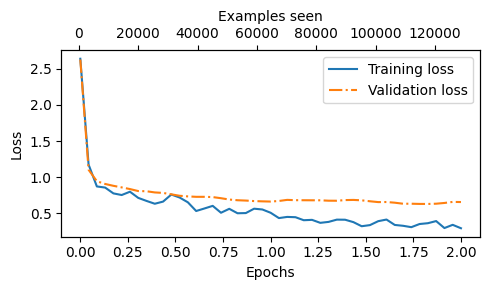

In [42]:
epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
plot_values(epochs_tensor, tokens_seen, train_losses, val_losses)

In [43]:
torch.manual_seed(123)
for entry in test_data[:3]:
    input_text = format_input(entry)
    token_ids = generate(
    model=model,
    idx=text_to_ids(input_text, tokenizer).to(device),
    max_new_tokens=256,
    context_size=BASE_CONFIG["context_length"],
    eos_id=50256
    )
    generated_text = ids_to_text(token_ids, tokenizer)

    response_text = (
    generated_text[len(input_text):]
    .replace("### Response:", "")
    .strip()
    )
    print(input_text)
    print(f"\nCorrect response:\n>> {entry['output']}")
    print(f"\nModel response:\n>> {response_text.strip()}")
    print("-----------------------------")

Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Rewrite the sentence using a simile.

### Input:
The car is very fast.

Correct response:
>> The car is as fast as lightning.

Model response:
>> The car is as fast as a bullet.
-----------------------------
Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
What type of cloud is typically associated with thunderstorms?

Correct response:
>> The type of cloud typically associated with thunderstorms is cumulonimbus.

Model response:
>> The type of cloud associated with thunderstorms is a cumulus cloud.
-----------------------------
Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Name the author of 'Pride and Prejudice'.

Correct response:
>> Jane Austen.

Model response:
>> The author of 'Pride and Prejudice' is Jane A

In [44]:
from tqdm import tqdm
for i, entry in tqdm(enumerate(test_data), total=len(test_data)):
    input_text = format_input(entry)
    token_ids = generate(
    model=model,
    idx=text_to_ids(input_text, tokenizer).to(device),
    max_new_tokens=256,
    context_size=BASE_CONFIG["context_length"],
    eos_id=50256
    )
    generated_text = ids_to_text(token_ids, tokenizer)

    response_text = (
    generated_text[len(input_text):]
    .replace("### Response:", "")
    .strip()
    )
    test_data[i]["model_response"] = response_text
    with open("instruction-data-with-response.json", "w") as file:
        json.dump(test_data, file, indent=4)

100%|██████████| 110/110 [01:16<00:00,  1.45it/s]


In [45]:
print(test_data[0])

{'instruction': 'Rewrite the sentence using a simile.', 'input': 'The car is very fast.', 'output': 'The car is as fast as lightning.', 'model_response': 'The car is as fast as a bullet.'}


In [46]:
import re
file_name = f"{re.sub(r'[ ()]', '', CHOOSE_MODEL) }-sft.pth"
torch.save(model.state_dict(), file_name)
print(f"Model saved as {file_name}")

Model saved as gpt2-medium355M-sft.pth
